# Series de tiempo - Ejercicio Francisco Devaux

En este notebook se presenta un ejercicio de series de tiempo utilizando un dataset de medallas olímpicas dado por la cátedra.

El objetivo es predecir la cantidad de medallas obtenidas por un país en un deporte en particular a lo largo de los años.

El dataset utilizado está disponible en el siguiente enlace:
https://www.kaggle.com/datasets/divyansh22/summer-olympics-medals


### Importación de librerías y lectura de datos

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Detectar la codificación del archivo
import chardet

with open('data.csv', 'rb') as f:
    result = chardet.detect(f.read())

encoding = result['encoding']
# Leer el archivo con la codificación detectada
data = pd.read_csv('data.csv', encoding=encoding)

### Análisis Exploratorio de datos

El dataset contiene la información de las medallas obtenidas en los juegos olímpicos desde 1896 hasta 2008. Las columnas son las siguientes:

Columnas:
- City
- Year
- Sport
- Discipline
- Event
- Athlete
- Gender
- Country_Code
- Country
- Event_gender
- Medal

In [31]:
data.head()

,City,Year,Sport,Discipline,Event,Athlete,Gender,Country_Code,Country,Event_gender,Medal
0,Montreal,1976.0,Aquatics,Diving,3m springboard,"KÖHLER, Christa",Women,GDR,East Germany,W,Silver
1,Montreal,1976.0,Aquatics,Diving,3m springboard,"KOSENKOV, Aleksandr",Men,URS,Soviet Union,M,Bronze
2,Montreal,1976.0,Aquatics,Diving,3m springboard,"BOGGS, Philip George",Men,USA,United States,M,Gold
3,Montreal,1976.0,Aquatics,Diving,3m springboard,"CAGNOTTO, Giorgio Franco",Men,ITA,Italy,M,Silver
4,Montreal,1976.0,Aquatics,Diving,10m platform,"WILSON, Deborah Keplar",Women,USA,United States,W,Bronze


Como fue solicitado en la consigna, observamos la cantidad de deportes que hay en el dataset y nos quedamos con los 5 con mas datos

In [32]:
# Obtener el numero de deportes
deportes = data['Sport'].unique()
print('Numero de deportes:', len(deportes))

#Guardamos los 5 deportes con mas datos
deportes = data['Sport'].value_counts().head().index
print(deportes)

# Mostrar los primeros 5 deportes con mas datos
data['Sport'].value_counts().head()

Numero de deportes: 29
Index(['Aquatics', 'Athletics', 'Rowing', 'Hockey', 'Gymnastics'], dtype='object', name='Sport')


Sport
Aquatics      2210
Athletics     1523
Rowing        1377
Hockey         817
Gymnastics     783
Name: count, dtype: int64

El valor a predecir será el numero de medallas ganadas por un país en un año y en un deporte en particular.

A continuación se intentará predecir las medallas obtenidas por Estados Unidos en el deporte de natación 

Antes de eso se visualizará graficamente la cantidad de medallas obtenidas por Estados Unidos en natación a lo largo de los años.

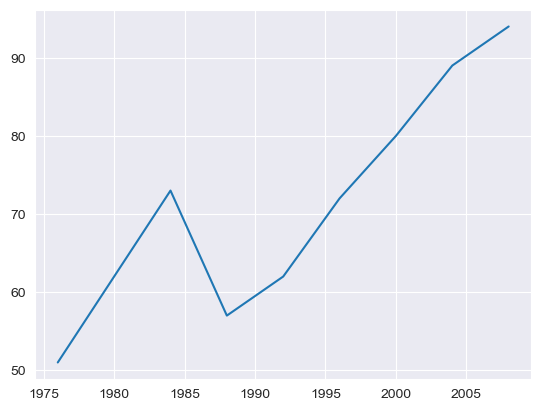

In [33]:
medals_data = data.groupby(['Year', 'Country', 'Sport'])['Medal'].count().reset_index()
medals_data_usa = medals_data[medals_data['Country'] == 'United States']
medals_data_usa_swimming = medals_data_usa[medals_data_usa['Sport'] == 'Aquatics'].copy()
plt.plot(medals_data_usa_swimming['Year'], medals_data_usa_swimming['Medal'])
plt.show()


Para predecir el número de medallas utilizando series de tiempo se utilizará un modelo LSTM. Se normalizarán los datos y se dividirán en conjuntos de entrenamiento, validación y prueba.

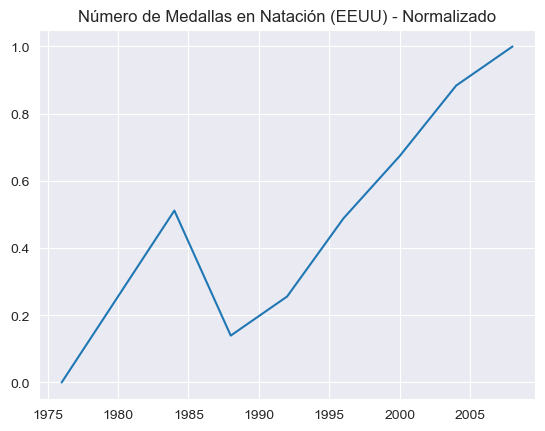

Tamaño de los datos de entrenamiento: (5, 1)
Tamaño de los datos de validación: (1, 1)
Tamaño de los datos de prueba: (2, 1)
Datos de entrenamiento: 
 [[0.        ]
 [0.51162791]
 [0.13953488]
 [0.25581395]
 [0.48837209]] 

Datos de validación: 
 [[0.6744186]] 

Datos de prueba: 
 [[0.88372093]
 [1.        ]] 



In [34]:
# Extraer solo la columna de medallas para la normalización
medals_values = medals_data_usa_swimming['Medal'].values.reshape(-1, 1)

# Normalizar los datos de medallas usando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
medals_values_scaled = scaler.fit_transform(medals_values)

# Usar .loc para evitar el warning
medals_data_usa_swimming.loc[:, 'Medal_scaled'] = medals_values_scaled

# Visualizar los datos normalizados
plt.plot(medals_data_usa_swimming['Year'], medals_data_usa_swimming['Medal_scaled'])
plt.title('Número de Medallas en Natación (EEUU) - Normalizado')
plt.show()

# Dividir en train, val, y test
train_data = medals_data_usa_swimming[:5][['Medal_scaled']].values  
val_data = medals_data_usa_swimming[5:6][['Medal_scaled']].values
test_data = medals_data_usa_swimming[6:] [['Medal_scaled']].values 

print("Tamaño de los datos de entrenamiento:", train_data.shape)
print("Tamaño de los datos de validación:", val_data.shape)
print("Tamaño de los datos de prueba:", test_data.shape)

# Opcional: visualizar las divisiones de los datos
print("Datos de entrenamiento: \n", train_data, "\n")
print("Datos de validación: \n", val_data, "\n")
print("Datos de prueba: \n", test_data, "\n")


A continuación se crea la función create_sequences que toma los datos y crea secuencias de tamaño time_steps. Luego se crean las secuencias para los conjuntos de entrenamiento y prueba.

In [35]:

def create_sequences(data, time_steps):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i+time_steps])
        labels.append(data[i+time_steps])
    return np.array(sequences), np.array(labels)


# Definir el tamaño de la ventana de tiempo (1 paso)
time_steps = 1

# Crear las secuencias para el conjunto de entrenamiento y prueba
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

# Para el conjunto de validación, dado que es un solo valor, lo ajustamos manualmente
X_val = np.array([[val_data[0]]])  # Solo un dato, sin secuencia
y_val = val_data[0]  # Etiqueta correspondiente

# Mostrar la forma de los datos para verificar
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (4, 1, 1)
y_train shape: (4, 1)
X_val shape: (1, 1, 1)
y_val shape: (1,)


A continuación se crea el modelo LSTM y se entrena con los datos de entrenamiento y validación.

In [36]:
# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=1)


Epoch 1/50
4/4 [==============================] - 0s 22ms/step - loss: 0.1458 - val_loss: 0.4476
Epoch 2/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1404 - val_loss: 0.4322
Epoch 3/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1348 - val_loss: 0.4173
Epoch 4/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1303 - val_loss: 0.4024
Epoch 5/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1256 - val_loss: 0.3882
Epoch 6/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1203 - val_loss: 0.3748
Epoch 7/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1164 - val_loss: 0.3616
Epoch 8/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1128 - val_loss: 0.3486
Epoch 9/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1079 - val_loss: 0.3367
Epoch 10/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1045 - val_loss: 0.3248
Epoch 11/50
4/4 [=====================

Finalmente se evalúa el modelo con los datos de prueba y se hacen predicciones. Al ser un solo valor, se desnormaliza y se compara con el valor real.

1/1 [==============================] - 0s 94ms/step - loss: 0.3704
Test Loss: 0.37041574716567993


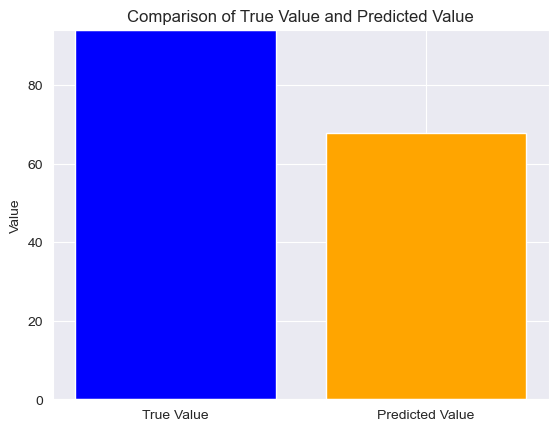

In [37]:

# Evaluar el modelo en los datos de prueba
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

@tf.function
def make_predictions(model, data):
    return model(data)

# Hacer predicciones sobre los datos de prueba
y_pred = make_predictions(model, X_test)

# Suponiendo que y_test y y_pred son numpy arrays
real_value = scaler.inverse_transform(y_test.reshape(-1, 1))[0][0]  # Valor real desnormalizado
predicted_value = scaler.inverse_transform(y_pred)[0][0]  # Valor predicho desnormalizado

# Crear listas para graficar
values = [real_value, predicted_value]
labels = ['True Value', 'Predicted Value']

plt.bar(labels, values, color=['blue', 'orange'])
plt.ylabel('Value')
plt.title('Comparison of True Value and Predicted Value')
plt.ylim(0, max(values) + 0.1)  # Ajustar el límite superior para mayor claridad
plt.show()

